# Alzheimers Multi Class Classification

# Process Data

## Import Packages

In [1]:
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import tensorflow as tf
import keras_cv
from tensorflow.data import AUTOTUNE
import tensorflow.keras as keras
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from tensorflow.keras.layers import (
    RandomBrightness, RandomZoom, RandomFlip,
    Input, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, Dense
)

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Using TensorFlow backend


## Load Data

In [2]:
class_names = ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
image_size = (176,208)

train_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/train', 
    color_mode = 'grayscale',
    class_names = class_names,
    image_size = image_size,
    label_mode = 'categorical',
    batch_size = 10000
)

val_data = tf.keras.utils.image_dataset_from_directory(
    '/kaggle/input/alzheimers-dataset-4-class-of-images/Alzheimer_s Dataset/test', 
    color_mode = 'grayscale',
    class_names = class_names,
    image_size = image_size,
    label_mode = 'categorical',
    batch_size = 10000
)

Found 5121 files belonging to 4 classes.
Found 1279 files belonging to 4 classes.


## Convert to Numpy Arrays

In [3]:
X_train, y_train = train_data.as_numpy_iterator().next()
X_val, y_val = val_data.as_numpy_iterator().next()

X = np.concatenate([X_train,X_val],axis=0)
y = np.concatenate([y_train,y_val],axis=0)
image_data = list(zip(X,y))

## View Class Imbalance

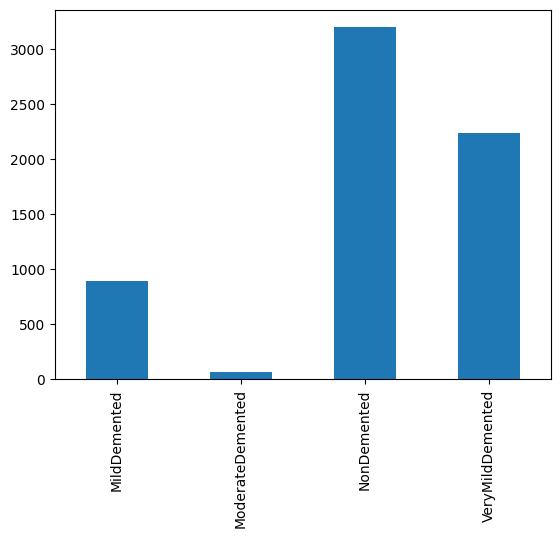

In [4]:
def plot_imbalance(y):
    class_totals = pd.Series([0,0,0,0], index = class_names)
    y_sparse = np.argmax(y, axis = -1)
    for i,class_name in enumerate(class_names):
        total = np.sum(y_sparse == i)
        class_totals[class_name] = total
    class_totals.plot.bar()
    
plot_imbalance(y)

## View Data

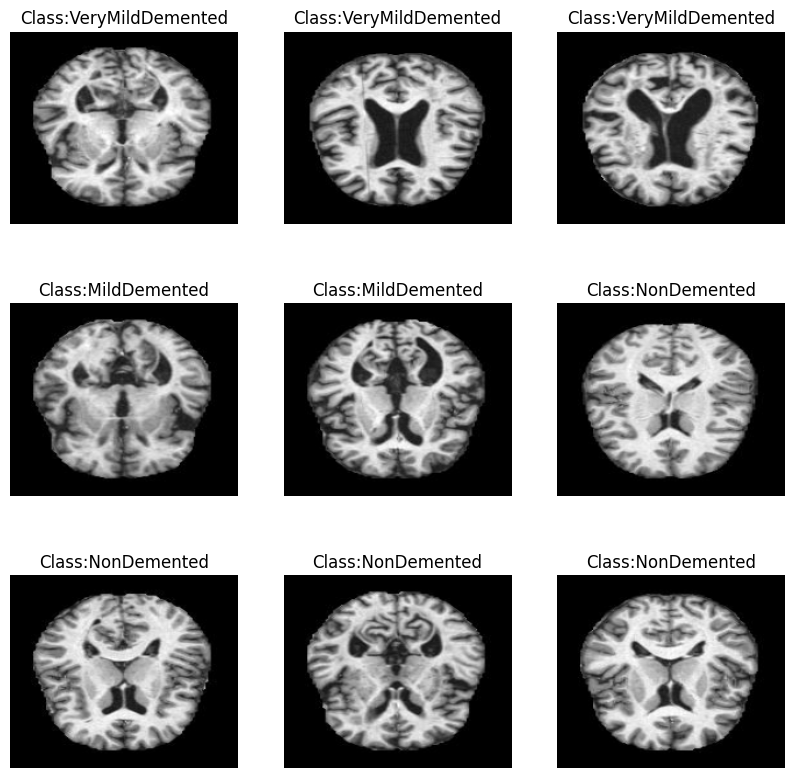

In [5]:
def show_images(image_data, random = True):
    """
    Input: An image list
    Output: Displays a grid of 9 images with lables
    """
    
    # get image lables
    labels =dict(zip([0,1,2,3], class_names))
    
    # get a batch of images
    
    # display a grid of 9 images
    plt.figure(figsize=(10, 10))
    for i in range(9):
        if random:
            idx = np.random.randint(0,5000)
        else:
            idx = i
        x = image_data[idx][0]
        y = image_data[idx][1]
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(x, cmap = 'gray')
        plt.axis("off")
        plt.title("Class:{}".format(labels[np.argmax(y)]))
    
# Display Train Images
show_images(image_data)

## Plot Brightness

Some of the examples look abnormally dark.

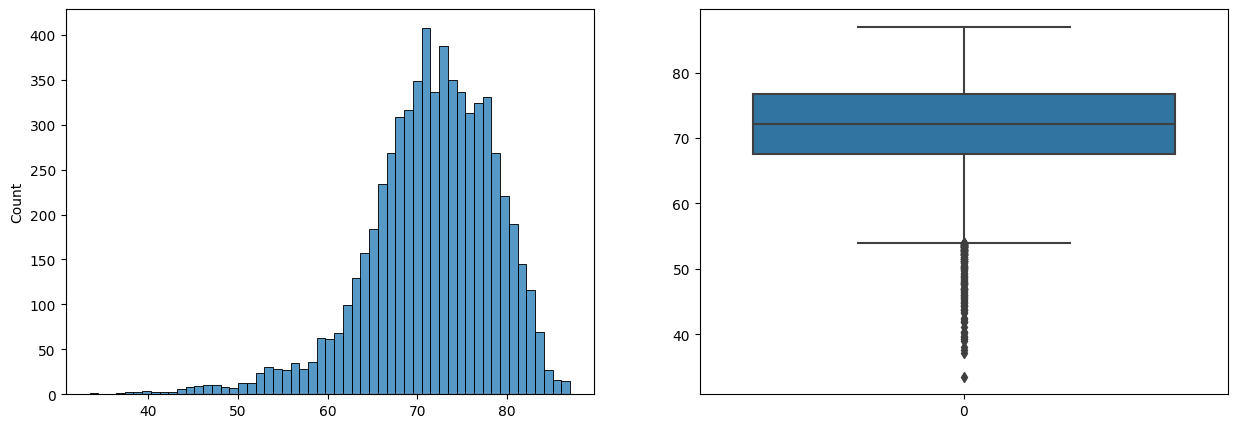

In [6]:
def plot_brightness(image_data):
    brightness = []

    for image, label in image_data:
        brightness.append(np.mean(image))

    plt.figure(figsize = (15,5))
    plt.subplot(1,2,1)
    sns.histplot(brightness)
    plt.subplot(1,2,2)
    sns.boxplot(brightness)
    
plot_brightness(image_data)

## View Outliers

In [7]:
def show_outliers():
    brightness = []

    for image, label in image_data:
        brightness.append(np.mean(image))

    q1 = np.quantile(brightness,.25)
    iqr = np.subtract(*np.percentile(brightness, [75, 25]))
    lower_fence = q1 - 1.5*iqr
    print('lower fence:',lower_fence)

    outliers = []
    for x,label in zip(X,y):
        if np.mean(x) < lower_fence:
            outliers.append((x,y))

    print('number of outliers:', len(outliers))
    show_images(outliers, False)
    
show_outliers

<function __main__.show_outliers()>

## Reassign Outlier Brightness

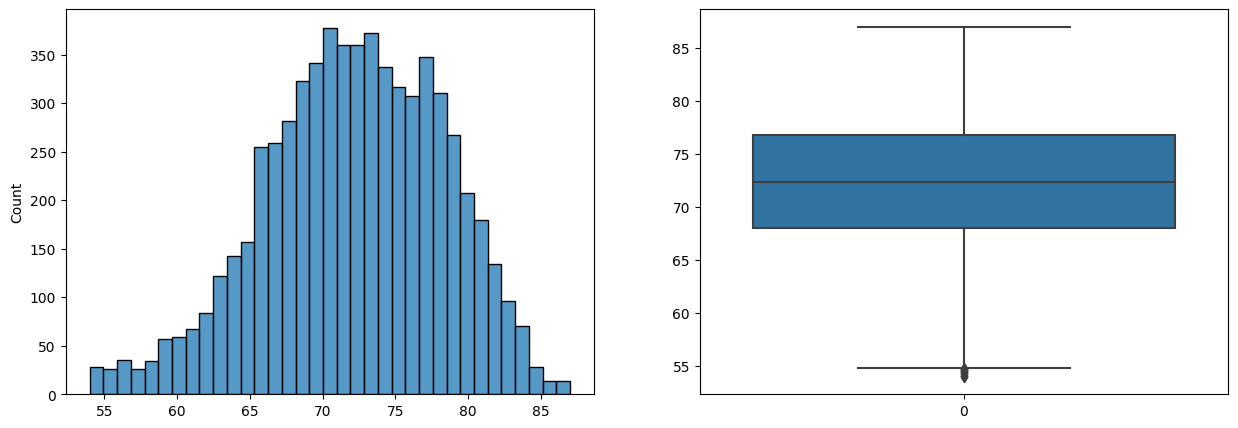

In [8]:
def unskew_brightness(image_data):
    
    brightness = []

    for image, label in image_data:
        brightness.append(np.mean(image))
    
    mew = np.median(brightness)
    q1 = np.quantile(brightness,.25)
    iqr = np.subtract(*np.percentile(brightness, [75, 25]))
    lower_fence = q1 - 1.5*iqr
    sigma = iqr/1.35
    
    unskewed = []
    
    for i,(image, label) in enumerate(image_data):
        
        if brightness[i] < lower_fence:
            new_image = sigma*np.clip(np.random.randn(1),-1,1)+mew*(image/brightness[i])
        else:
            new_image = image
        unskewed.append((new_image,label))
        
    return unskewed
    
    
image_data = unskew_brightness(image_data)
plot_brightness(image_data)

Most of the darkened images were removed put some brighter outliers blend in with the brightness of normal images so not all are accounted for. 

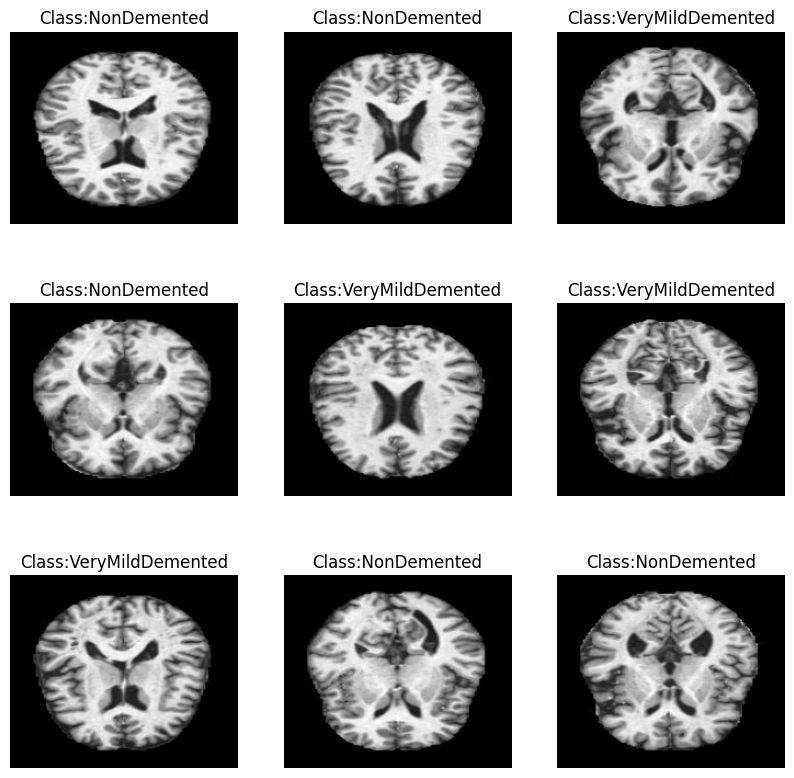

In [9]:
show_images(image_data)

## Process Data

Use SMOTE to resample minority classes with synthetic new examples.

In [10]:
split_percent = 5121/len(y)

def process_data(X,y,split_percent):
    sm = SMOTE()  
    
    shuffle = np.arange(len(y))
    np.random.shuffle(shuffle)
    
    X = X[shuffle]/255.
    y = y[shuffle].astype('float')
    
    split = int(split_percent*len(y))

    X_train = X[:split]
    y_train = y[:split]

    X_val = X[split:]
    y_val = y[split:]

    X_train, y_train = sm.fit_resample(X_train.reshape(X_train.shape[0],-1),y_train)



    X_train = X_train.reshape(-1,*image_size,1)/255.

    
    return X_train, y_train, X_val, y_val

X_train, y_train, X_val, y_val = process_data(X,y,split_percent)

Checking to make sure SMOTE created good examples

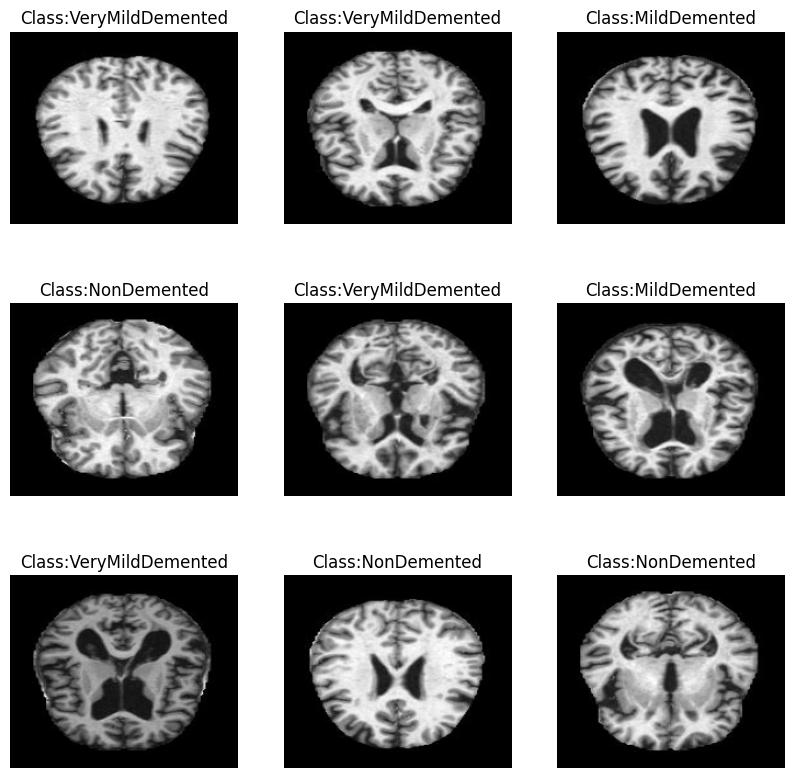

In [11]:
show_images(list(zip(X_train,y_train)))

We can now train now a balanced dataset

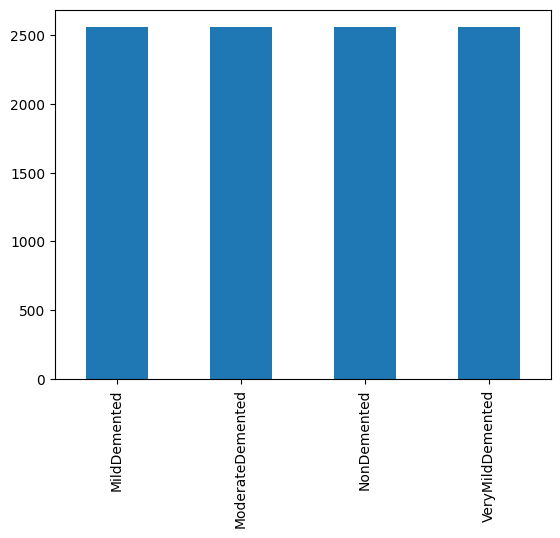

In [12]:
plot_imbalance(y_train)

In [13]:
X_train.shape, X_val.shape

((10228, 176, 208, 1), (1279, 176, 208, 1))

## Add Data Augmentation

We have to be careful with our augmentation because each picture is taken in a similiar meanner, so we will do our augmentation in a minimal fashion. This makes it so that we still get the regularizing effect of sligthly varying the data in meaningful ways but not disrupting the models ability to analyze the way images were positioned.

In [14]:
aug = keras.Sequential([
    Input(shape = (*image_size,1)),
    keras_cv.layers.AutoContrast((0,1)),
    RandomBrightness(0.15, value_range = (0,1)),
    keras_cv.layers.RandomShear(x_factor = 0.01),
    RandomZoom(0.01, fill_mode = 'constant'),
    RandomFlip('horizontal')
])

# Create Model
Here I use a class to make tuning the model easier. The data is also converted into a tensorflow dataset with best practices for optimal results and performance used.

In [15]:
AUC = keras.metrics.AUC(curve = 'PR')

class disease_model:
    def __init__(self, model = None, weight_decay = None):
        self.model = model
        self.weight_decay = weight_decay
    
    def create_dataset(self,X,y,epochs,batch_size, train = True):
        ds = tf.data.Dataset.from_tensor_slices((X,y))
        ds = ds.cache()
        ds = ds.shuffle(y.shape[0])
        ds = ds.batch(batch_size)
        if train:
            ds = ds.map(lambda image,label: (aug(image), label), num_parallel_calls = AUTOTUNE)
        ds = ds.repeat(epochs)
        ds = ds.prefetch(AUTOTUNE)

        return ds
    def conv_block(self,filters, dropout, batchnorm = True):
        block = [
            Conv2D(filters,3, activation = 'leaky_relu', kernel_initializer = 'he_uniform', padding = 'same'),
            Conv2D(filters,3, activation = 'leaky_relu', kernel_initializer = 'he_uniform', padding = 'same')
        ]
        if batchnorm:
            block.append(BatchNormalization())
        block.append(MaxPool2D())
        block.append(Dropout(dropout))
        
        return block

    def dense_block(self,units, dropout):

        return [
            Dense(units, activation = 'leaky_relu', kernel_initializer = 'he_uniform'),
            BatchNormalization(),
            Dropout(dropout)
        ]

    def create_model(self, learning_rate = 1e-3):

        self.model = keras.Sequential([
            Input(shape = (*image_size,1)),
            *self.conv_block(16, 0.5, False),
            *self.conv_block(32, 0.2),
            *self.conv_block(64, 0.2),
            *self.conv_block(128, 0.2),
            *self.conv_block(256,0.1),
            Flatten(),
            *self.dense_block(512, 0.5),
            *self.dense_block(256, 0.35),
            *self.dense_block(128, 0.2),
            *self.dense_block(64, 0.2),
            Dense(4)
        ])
        
        opt = keras.optimizers.Adam(learning_rate, weight_decay = self.weight_decay)

        self.model.compile(loss = keras.losses.CategoricalCrossentropy(from_logits = True), optimizer = 'adam', metrics = ['accuracy',AUC])

        return self.model
    
    def train_model(self,epochs = 1, batch_size = 32, decay_step = 100, learning_rate = 1e-3):
        if not self.model:
            self.model = self.create_model(learning_rate)
        checkpointer = tf.keras.callbacks.ModelCheckpoint(
            filepath='/kaggle/working/checkpoint',
            monitor='val_auc',
            mode='max',
            save_best_only=True)
        step_decay = keras.callbacks.LearningRateScheduler(
            lambda epoch: learning_rate*10**(-int(epoch/decay_step))
        )
        train_ds = self.create_dataset(X_train,y_train,epochs,batch_size)
        val_ds = self.create_dataset(X_val,y_val,epochs,batch_size, train = False)
        history = self.model.fit(train_ds, steps_per_epoch = y_train.shape[0]//batch_size,
                  validation_data = val_ds, validation_steps = y_val.shape[0]//batch_size,
                  epochs = epochs, callbacks = [step_decay,checkpointer])

        return self.model, history

## View Model

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_40 (Conv2D)          (None, 176, 208, 16)      160       
                                                                 
 conv2d_41 (Conv2D)          (None, 176, 208, 16)      2320      
                                                                 
 max_pooling2d_20 (MaxPoolin  (None, 88, 104, 16)      0         
 g2D)                                                            
                                                                 
 dropout_36 (Dropout)        (None, 88, 104, 16)       0         
                                                                 
 conv2d_42 (Conv2D)          (None, 88, 104, 32)       4640      
                                                                 
 conv2d_43 (Conv2D)          (None, 88, 104, 32)       9248      
                                                      

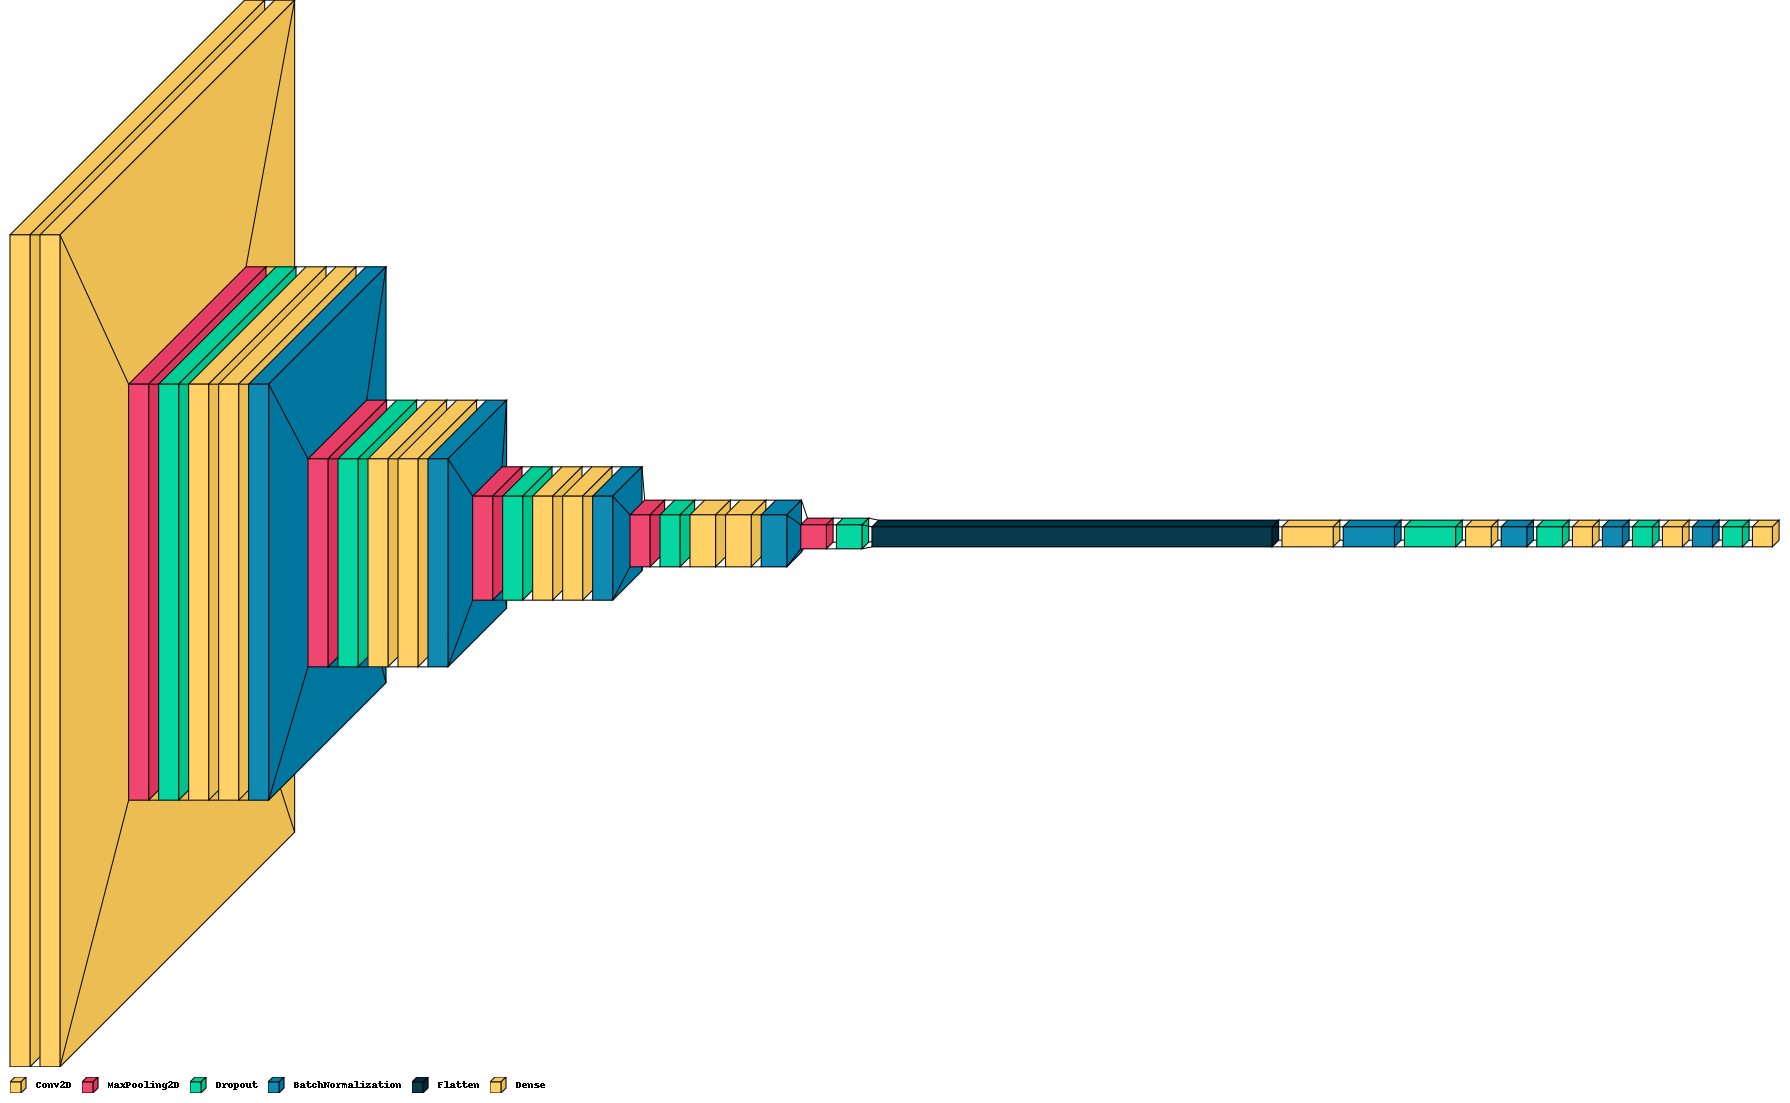

In [32]:
!pip install visualkeras
from visualkeras import layered_view

test_model = disease_model().create_model()

test_model.summary()
layered_view(test_model, legend=True)

# Train Model

In [17]:
modelling_class = disease_model(weight_decay = 1e-2)
model, history = modelling_class.train_model(epochs = 160, decay_step = 50)

Epoch 1/160


2023-09-13 22:12:49.780713: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_2/dropout_9/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


319/319 [==============================] - 55s 116ms/step - loss: 1.3855 - accuracy: 0.3946 - auc: 0.3432 - val_loss: 1.2162 - val_accuracy: 0.3670 - val_auc: 0.3286 - lr: 0.0010
Epoch 2/160
319/319 [==============================] - 37s 112ms/step - loss: 0.8656 - accuracy: 0.6007 - auc: 0.5024 - val_loss: 0.9087 - val_accuracy: 0.5553 - val_auc: 0.4095 - lr: 0.0010
Epoch 3/160
319/319 [==============================] - 36s 114ms/step - loss: 0.7204 - accuracy: 0.6687 - auc: 0.5293 - val_loss: 0.8741 - val_accuracy: 0.5705 - val_auc: 0.4596 - lr: 0.0010
Epoch 4/160
319/319 [==============================] - 37s 117ms/step - loss: 0.6405 - accuracy: 0.7072 - auc: 0.5489 - val_loss: 0.7530 - val_accuracy: 0.6186 - val_auc: 0.4634 - lr: 0.0010
Epoch 5/160
319/319 [==============================] - 27s 86ms/step - loss: 0.5645 - accuracy: 0.7496 - auc: 0.5622 - val_loss: 0.9297 - val_accuracy: 0.6018 - val_auc: 0.4564 - lr: 0.0010
Epoch 6/160
319/319 [==============================] - 39s

## Get Best Model From Training

In [23]:
checkpoint_path = '/kaggle/working/checkpoint'
best_model = keras.models.load_model(checkpoint_path)
best_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 176, 208, 16)      160       
                                                                 
 conv2d_11 (Conv2D)          (None, 176, 208, 16)      2320      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 88, 104, 16)      0         
 2D)                                                             
                                                                 
 dropout_9 (Dropout)         (None, 88, 104, 16)       0         
                                                                 
 conv2d_12 (Conv2D)          (None, 88, 104, 32)       4640      
                                                                 
 conv2d_13 (Conv2D)          (None, 88, 104, 32)       9248      
                                                      

## Add Softmax Layer (Exluded for Training With Logits)

In [24]:
if best_model.layers[-1].name[:5] == 'dense':
    best_model.add(keras.layers.Activation('softmax'))
best_model.layers[-1].name

activation


## Evaluate Model Performance on Validation Data

In [27]:
def evaluate_model(model):
    y_sparse = np.argmax(y_val, axis = -1)
    recalls = []
    precisions = []
    F1_scores = []
    pred_prob = model.predict(X_val, batch_size = len(y_val))
    pred_labels = np.argmax(pred_prob, axis = -1)
    
    for i, class_name in enumerate(class_names):
        T_p = np.sum((pred_labels == i)*(y_sparse == i))
        F_p = np.sum((pred_labels == i)*(y_sparse != i))
        F_n = np.sum((pred_labels !=i )*(y_sparse == i))
        
        recall = T_p/(T_p + F_n)
        precision = T_p/(T_p + F_p)
        F1 = 2/((1/recall)+(1/precision))
        
        recalls.append(recall)
        precisions.append(precisions)
        F1_scores.append(F1)
        
        print(class_name, ' recall: ', recall)
        print(class_name, ' precision: ', precision)
        print(class_name, ' F1: ', F1)
        
    macro_F1 = np.mean(F1_scores)
    
    print('Average F1: ', macro_F1)
        
evaluate_model(best_model)

1/1 [==============================] - 0s 215ms/step
MildDemented  recall:  1.0
MildDemented  precision:  0.9935064935064936
MildDemented  F1:  0.996742671009772
ModerateDemented  recall:  1.0
ModerateDemented  precision:  1.0
ModerateDemented  F1:  1.0
NonDemented  recall:  0.9968895800933126
NonDemented  precision:  0.990726429675425
NonDemented  F1:  0.9937984496124033
VeryMildDemented  recall:  0.987152034261242
VeryMildDemented  precision:  0.9978354978354979
VeryMildDemented  F1:  0.9924650161463942
Average F1:  0.9957515341921424


## Save Model

In [28]:
best_model.save('AlzheimersModel.h5')